# 𝁘 Notație Bizantină (Byzantine Notation) 𝁑

> Neural Network Approach

## Statement

Byzantine music is a genre with ancient origins, widespread throughout the Balkan region, with a history spanning more than a millennium. Its specific notation consists of a series of signs called neumes. The most important neumes are the vocalic ones, which guide the singing in an ascending, descending, or stationary manner along the tonal scale of the melody, with a meaning that is relative to the last note sung.

Implement an AI model that classifies the neumes from a sequence stored in an image, and use this model to produce a sequence representing, for each neume encountered, in the order from the image, the number of steps accumulated up to the current neume relative to the initial pitch (considered at the beginning of the sequence).

You are provided with a number of labeled sample images for training, each of size 48 by 48 pixels, each representing a single sign.

The training dataset is a CSV file containing the following fields with the following meanings:

- `Path`: the relative path from the working directory to the sample image.
- `Effect`: the label assigned to the image at the path in `Path`, which can be either an integer or an uppercase letter. If it is an integer, then it also represents the number of steps by which the pitch changes due to the effect of the sign. If it is an uppercase letter (A or B), then the neume represented has no vocalic value, and the pitch remains unchanged.

## Notes about the training dataset

- The samples in the training set are extracted from multiple typographic works and manuscripts.
- In addition to the typical differences between samples corresponding to the same sign, the training set includes a group of distinctly shaped neumes with the same effect (label).

## Notes about the evaluation dataset

- The evaluation dataset is a CSV file with two fields: `subtaskID`, always having the value 1. `datapointID`, containing the relative path to the image representing the neume sequence to be recognized.
- Neume sequences in the images have a length between 1 and 15 distinct signs and are ordered from left to right.
- All neumes present in the sequences intended for recognition are found in the training dataset.
- Images may contain small artifacts or visual defects, so preprocessing is required.

## Notes about the output data format

The output file is a CSV file containing three fields:

- `subtaskID`: always the value 1.
- `datapointID`: the relative path to the image representing the neume sequence, in the same order as in the training set (in other words, the value of the `Path` field).
- `answer`: the recognized sequence, in the form of a sequence of integers separated by the `|` character, where each number represents the accumulated relative distance from the initial pitch up to the current sign, inclusive.

### Example

For the following sequence:

> 𝁇𝁕𝁇𝁆𝁆𝁑𝁘 𝁇𝁑𝁑

The individual tonal meaning of the neumes is 

```
1, -2, 1, 1, 1, -1, none, 1, -1, -1
```

and in the output file the sequence would be

```
1|-1|0|1|2|1|1|2|1|0
```

**Note:** The sequence above is rendered in Unicode. To view it in more detail, as an image, refer to `example-image.png` from the Starting Kit.

## Scoring

For each sequence in the output file, 1 point is awarded for correctly determining the number of neumes.

If the number of neumes is correct, an additional 1 point is awarded for each correctly classified neume.

For example, if the expected output was `1|2|0|0|1` but the actual output is `1|2|0|2|3`, the score for this result is 5 (out of a maximum score of 6).

The final score is the ratio of the total score obtained to the maximum possible total score (3354), expressed as a percentage, rounded up to the nearest whole number.

> This is an English translation of the original Romanian task description, generated by ChatGPT.

In [1]:
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

## Load data

In [2]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")
df_train

,Path,Effect
0,training_img/24-322.png,A
1,training_img/19-442.png,A
2,training_img/45-468.png,-1
3,training_img/44-315.png,B
4,training_img/45-27.png,B
...,...,...
411,training_img/689-999-3.png,4
412,training_img/689-999-4.png,4
413,training_img/689-999-5.png,4
414,training_img/777.png,0


In [3]:
classes = df_train["Effect"].unique()
df_train["Effect"].value_counts()

Effect
1     87
0     55
A     50
-1    50
-2    50
B     48
4     47
-4    29
Name: count, dtype: int64

In [4]:
enc = LabelEncoder()
train_labels = enc.fit_transform(df_train["Effect"])

In [5]:
df_test

,subtaskID,datapointID
0,1,eval_img/12.png
1,1,eval_img/14.png
2,1,eval_img/19.png
3,1,eval_img/20.png
4,1,eval_img/23.png
...,...,...
323,1,eval_img/s11r.png
324,1,eval_img/s12r.png
325,1,eval_img/s13r.png
326,1,eval_img/s14r.png


In [6]:
def load_image(path, *, return_np=False, black_and_white=True):
    img = np.array(Image.open(path).convert("L"))
    if black_and_white:
        mask = np.where(img < 128, 255, 0).astype(np.uint8)  # Invert threshold
    else:
        mask = (255 - img).astype(np.uint8)
    return mask if return_np else Image.fromarray(mask)

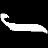

In [7]:
train_sample_img = load_image(df_train["Path"][42], black_and_white=False)
train_sample_img

In [8]:
train_sample_img.size

(48, 48)

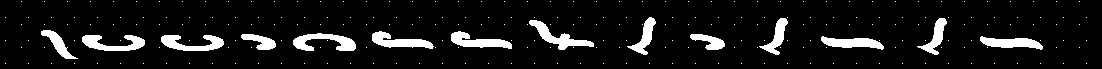

In [9]:
test_sample_img = load_image(df_test["datapointID"][270])
test_sample_img

In [10]:
def show_images(np_list, titles=None):
    plt.figure()
    for i, img in enumerate(np_list):
        plt.subplot(1, len(np_list), i + 1)
        plt.imshow(Image.fromarray(np_list[i]).convert("L"), cmap="gray")
        plt.xticks([])
        plt.yticks([])
        if titles is not None:
            plt.title(titles[i])

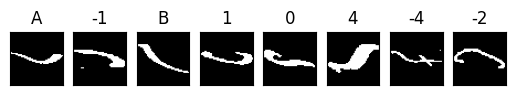

In [11]:
each_class_samples = [load_image(df_train[df_train["Effect"] == cls]["Path"].iloc[0], return_np=True) for cls in classes]
show_images(each_class_samples, classes)

## Partition sequences

In [12]:
test_sample_np = np.array(test_sample_img)
test_sample_np.shape

(69, 1102)

In [13]:
def pad_and_resize(img_np):
    h, w = img_np.shape
    max_dim = max(h, w)

    # Compute padding values
    top = (max_dim - h) // 2
    bottom = max_dim - h - top
    left = (max_dim - w) // 2
    right = max_dim - w - left

    # Apply padding
    img_np_padded = cv2.copyMakeBorder(img_np, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    # Resize to train image size
    img_np_resized = cv2.resize(img_np_padded, train_sample_img.size)
    return img_np_resized

In [14]:
def partition_sequence(image):
    image_np = np.array(image)
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])  # Sort contours by x coordinate (left to right)

    subimages = []
    for contour in contours:
        if cv2.contourArea(contour) > 10:  # Remove noise
            x, y, w, h = cv2.boundingRect(contour)
            
            image = pad_and_resize(image_np[y:y + h, x:x + w])
            image = np.where(image < 128, 0, 255).astype(np.uint8)
            subimages.append(image)
    return subimages

In [15]:
test_sample_parts = partition_sequence(test_sample_np)
len(test_sample_parts)

14

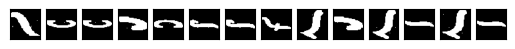

In [16]:
show_images(test_sample_parts)

In [17]:
test_images = [list(map(lambda img: img / 255, partition_sequence(load_image(i, return_np=True)))) for i in df_test["datapointID"]]

In [18]:
sum(len(seq) + 1 for seq in test_images) == 3354  # 3354 is the total score of this task

True

## Train model

In [19]:
train_images = [load_image(i, return_np=True, black_and_white=False) / 255 for i in df_train["Path"]]

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [21]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
def train(model, dataloader, criterion, optimizer, device):
    model = model.to(device)
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.float().to(device), labels.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(dataloader), correct / total

In [23]:
transformer = transforms.ToTensor()

In [24]:
train_images_tensor = [transformer(img) for img in train_images]
train_labels_tensor = torch.tensor(train_labels)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=len(classes)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(list(zip(train_images_tensor, train_labels_tensor)), batch_size=32)

In [26]:
seed_everything()

for epoch in range(15):
    loss, accuracy = train(model, train_dataloader, criterion, optimizer, device)
    print(f"Epoch {epoch + 1}: {loss=:.4f}, {accuracy=:.4f}")

Epoch 1: loss=1.7135, accuracy=0.3798
Epoch 2: loss=0.7779, accuracy=0.7428
Epoch 3: loss=0.4375, accuracy=0.8365
Epoch 4: loss=0.2724, accuracy=0.8966
Epoch 5: loss=0.1662, accuracy=0.9519
Epoch 6: loss=0.1312, accuracy=0.9688
Epoch 7: loss=0.0747, accuracy=0.9784
Epoch 8: loss=0.0446, accuracy=0.9832
Epoch 9: loss=0.0496, accuracy=0.9808
Epoch 10: loss=0.0370, accuracy=0.9904
Epoch 11: loss=0.0174, accuracy=0.9976
Epoch 12: loss=0.0536, accuracy=0.9832
Epoch 13: loss=0.0314, accuracy=0.9928
Epoch 14: loss=0.0237, accuracy=0.9928
Epoch 15: loss=0.0181, accuracy=0.9952


## Make predictions

In [27]:
@torch.no_grad()
def predict(model, images, device):
    model.eval()
    
    if isinstance(images, list):
        images = torch.stack([transformer(img) for img in images])
    
    images = images.float().to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    return preds.cpu().tolist()

In [28]:
def to_tone(s):
    try:
        return int(s)
    except ValueError:
        return 0

In [29]:
preds = []
for sequence in test_images:
    neumes = list(map(lambda x: int(x) if to_tone(x) else 0, enc.inverse_transform(predict(model, sequence, device))))
    for i in range(1, len(neumes)):
        neumes[i] += neumes[i - 1]

    preds.append("|".join(map(str, neumes)))

In [30]:
answer_rows = []
for id_, val in zip(df_test["datapointID"], preds):
    answer_rows.append((1, id_, val))

## Save answers

In [31]:
df_submission = pd.DataFrame(answer_rows, columns=["subtaskID", "datapointID", "answer"])
df_submission.to_csv("submission-NN.csv", index=False)

## Submission results

Subtask 1:
- Raw: 3347/3354
- Score: 100/100